# Winning Jeopardy

Jeopardy is a popular TV show in the US where participants answer questions to win money. It's been running for many years, and is a major force in popular culture.

In this project, we will look for a way to win by working with a dataset of Jeopardy questions to figure out some patterns in the questions that could help you win.

The data set is found [here](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file).

In [191]:
import pandas as pd

jeopardy = pd.read_csv('jeopardy.csv')
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,"No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves",Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,"The city of Yuma in this state has a record average of 4,055 hours of sunshine each year",Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", this company served its billionth burger",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Constitution of Mass., second President of the United States",John Adams


In [192]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [193]:
jeopardy.columns = jeopardy.columns.str.strip()
print(jeopardy.columns)

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')


## Cleaning the Data Set

Now, we will normalize the question and answer by making it lowercase and removing any non-alphanumeric or converting any excessive whitespace to a single whitespace character. For any integer columns, the value will be cleaned and casted to an integer. The air date column will also be cast to datetime.

In [194]:
import re

def normalize_text(text: str) -> str:
    '''
    text: a string that will become lowercase, and any non-alphanumeric or whitespace characters will be removed
    '''
    
    text = str(text)
    text = text.lower()
    text = re.sub("[^A-Za-z0-9\s]", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

jeopardy["clean_question"] = jeopardy["Question"].apply(normalize_text)
jeopardy["clean_answer"] = jeopardy["Answer"].astype('string').apply(normalize_text)

In [195]:
def normalize_values(text: str) -> int:
    '''
    text: a string that will have any non-alphanumeric characters will be removed and cast to an integer
    '''
    text = re.sub("[^A-Za-z0-9\s]", "", text)
    try:
        text = int(text)
    except Exception:
        text = 0
    return text

jeopardy["clean_value"] = jeopardy["Value"].apply(normalize_values)

In [196]:
jeopardy["Air Date"] = pd.to_datetime(jeopardy["Air Date"])

In [197]:
jeopardy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Show Number     216930 non-null  int64         
 1   Air Date        216930 non-null  datetime64[ns]
 2   Round           216930 non-null  object        
 3   Category        216930 non-null  object        
 4   Value           216930 non-null  object        
 5   Question        216930 non-null  object        
 6   Answer          216928 non-null  object        
 7   clean_question  216930 non-null  object        
 8   clean_answer    216930 non-null  object        
 9   clean_value     216930 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 16.6+ MB


In [198]:
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory",Copernicus,for the last 8 years of his life galileo was under house arrest for espousing this mans theory,copernicus,200
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,"No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves",Jim Thorpe,no 2 1912 olympian football star at carlisle indian school 6 mlb seasons with the reds giants braves,jim thorpe,200
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,"The city of Yuma in this state has a record average of 4,055 hours of sunshine each year",Arizona,the city of yuma in this state has a record average of 4055 hours of sunshine each year,arizona,200
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", this company served its billionth burger",McDonald's,in 1963 live on the art linkletter show this company served its billionth burger,mcdonalds,200
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Constitution of Mass., second President of the United States",John Adams,signer of the dec of indep framer of the constitution of mass second president of the united states,john adams,200


## Answer and Question Analysis

Now that the dataset is cleaned, in this section, we will figure out two things:

* How often the answer can be used for a question.
* How often questions are repeated.

We can answer the second question by seeing how often complex words (> 6 characters) reoccur.
We can answer the first question by seeing how many times words in the answer also occur in the question.

### Creating a Stop Words List

Before we can answer any of the above questions, we need to create a list of words that are usual stop words such as the or than. We will be working with the nltk package and you will have to download the stopwords using the below code block:

In [199]:
import nltk
import ssl
from nltk.corpus import stopwords

# Creates an SSL certificate if not present to then download
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielsolis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [200]:
stopwords = set(stopwords.words('english'))

In [201]:
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

### Answer in the Question

Now that we have the stopword list, to answer the first question "How often the answer can be used for a question?", we'll look at what percentage of the answer is in the questio on average.

In [202]:
def count_matches(row: pd.Series) -> float:
    '''
    returns the proportion of the answer that is in the questions where each word is less than 6 characters 
    and not a stop word
    '''
    split_answer = row['clean_answer'].split()
    split_question = row['clean_question'].split()
    match_count = 0
    
    if len(split_answer) == 0:
        return 0
    
    for item in split_answer:
        if item in stopwords and len(item) < 6:
            continue
        elif item in split_question:
            match_count += 1
    return match_count / len(split_answer)

jeopardy["answer_in_question"] = jeopardy.apply(count_matches, axis=1)

In [203]:
jeopardy["answer_in_question"].describe()

count    216930.000000
mean          0.033322
std           0.128014
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: answer_in_question, dtype: float64

On average, we see that the answer only makes up about 3% of the question which means that we can't normally rely on the answer from the question (or studying just the answers).

We can see though that for some questions the answer is 100% in the question, those would be interesting to keep tabs on.

In [204]:
pd.set_option('display.max_colwidth', None)
jeopardy[jeopardy["answer_in_question"] == 1].head(10)

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value,answer_in_question
266,4931,2006-02-06,Double Jeopardy!,NOT A CURRENT NATIONAL CAPITAL,$400,"Ljubljana, Bratislava, Barcelona",Barcelona,ljubljana bratislava barcelona,barcelona,400,1.0
272,4931,2006-02-06,Double Jeopardy!,NOT A CURRENT NATIONAL CAPITAL,$800,"Istanbul, Ottawa, Amman",Istanbul,istanbul ottawa amman,istanbul,800,1.0
278,4931,2006-02-06,Double Jeopardy!,NOT A CURRENT NATIONAL CAPITAL,$1200,"Sofia, Sarajevo, Saigon",Saigon,sofia sarajevo saigon,saigon,1200,1.0
284,4931,2006-02-06,Double Jeopardy!,NOT A CURRENT NATIONAL CAPITAL,$1600,"Bucharest, Bonn, Bern",Bonn,bucharest bonn bern,bonn,1600,1.0
290,4931,2006-02-06,Double Jeopardy!,NOT A CURRENT NATIONAL CAPITAL,$2000,"Belize City, Guatemala City, Panama City",Belize City,belize city guatemala city panama city,belize city,2000,1.0
1137,1279,1990-03-08,Jeopardy!,PEANUTS,$200,"Of a 25th, 30th or 40th anniversary, what ""Peanuts"" is celebrating in 1990",40th Anniversary,of a 25th 30th or 40th anniversary what peanuts is celebrating in 1990,40th anniversary,200,1.0
2572,4220,2002-12-27,Jeopardy!,THE PLANET URANUS,$400,"Of 84, 184 or 284, the length in years of one orbit by Uranus around the sun",84,of 84 184 or 284 the length in years of one orbit by uranus around the sun,84,400,1.0
2818,422,1986-04-22,Jeopardy!,STUPID ANSWERS,$300,"In 1842, Richard Owen coined this word for “dinosaur”",dinosaur,in 1842 richard owen coined this word for dinosaur,dinosaur,300,1.0
3225,5084,2006-10-19,Jeopardy!,THE HIGHEST-SCORING SCRABBLE WORD,$200,"Hell, heaven or limbo",heaven,hell heaven or limbo,heaven,200,1.0
3231,5084,2006-10-19,Jeopardy!,THE HIGHEST-SCORING SCRABBLE WORD,$400,"Vow, knight or grail",knight,vow knight or grail,knight,400,1.0


We can see in the above values that some of the questions are multiple choice such as those in the category "NOT A CURRENT NATIONAL CAPITAL". In this case, knowing that the answer is in the question provides no value as that is a given. However, the "STUPID ANSWERS" category might be of interest in this section.

In [205]:
jeopardy[(jeopardy["answer_in_question"] == 1) & (jeopardy["Category"] == 'STUPID ANSWERS')].head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value,answer_in_question
2818,422,1986-04-22,Jeopardy!,STUPID ANSWERS,$300,"In 1842, Richard Owen coined this word for “dinosaur”",dinosaur,in 1842 richard owen coined this word for dinosaur,dinosaur,300,1.0
10951,4362,2003-07-15,Jeopardy!,STUPID ANSWERS,$200,It's the first verb in the Pledge of Allegiance,pledge,its the first verb in the pledge of allegiance,pledge,200,1.0
10957,4362,2003-07-15,Jeopardy!,STUPID ANSWERS,$400,"The name of the Gobi, a vast desert of central Asia, means this in Mongolian",desert,the name of the gobi a vast desert of central asia means this in mongolian,desert,400,1.0
10963,4362,2003-07-15,Jeopardy!,STUPID ANSWERS,$600,"Charlie & David Kaufman got an Oscar nomination for their adaptation of ""The Orchid Thief"" into this film",Adaptation,charlie david kaufman got an oscar nomination for their adaptation of the orchid thief into this film,adaptation,600,1.0
15396,4239,2003-01-23,Jeopardy!,STUPID ANSWERS,$200,Florence Nightingale was born in this Italian city in 1820,Florence,florence nightingale was born in this italian city in 1820,florence,200,1.0


You can see above, the answer in question strategy works for those categories.

### Recycled Questions

Next, we can answer the following question "How often questions are repeated?" by seeing how often questions are repeated by seeing if there is overlap on complex words. This can allow for certain topics to be focused on.

In [206]:
question_overlap = []
terms_used = set()

# Sort by air date
jeopardy.sort_values("Air Date", inplace=True)

# Create a python iterator from the dataframe
for i, row in jeopardy.iterrows():
    split_question = row["clean_question"].split(" ")
    
    # Get words that are more than 5 characters
    split_question = [q for q in split_question if len(q) > 5 and q not in stopwords]
    match_count = 0

    # If word has been used before
    for word in split_question:
        if word in stopwords:
            continue
        if word in terms_used:
            match_count += 1
        terms_used.add(word)        

    # If the question is not null
    if len(split_question) > 0:
        match_count /= len(split_question)

    question_overlap.append(match_count)
        
jeopardy["question_overlap"] = question_overlap
jeopardy["question_overlap"].describe()

count    216930.000000
mean          0.870946
std           0.231204
min           0.000000
25%           0.800000
50%           1.000000
75%           1.000000
max           1.000000
Name: question_overlap, dtype: float64

Below, we will attempt to visualize the above information by year.

In [207]:
jeopardy['year'] = jeopardy['Air Date'].dt.to_period('Y')

<AxesSubplot:title={'center':'question_overlap'}, xlabel='year'>

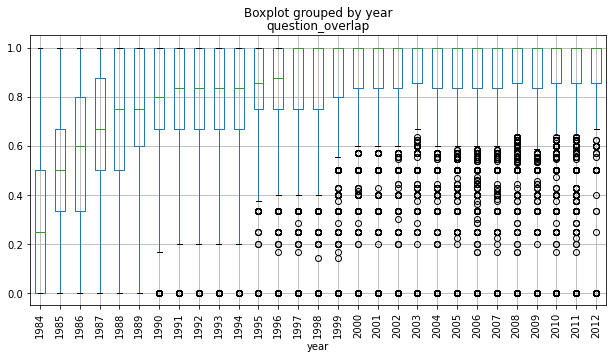

In [208]:
jeopardy.boxplot(column='question_overlap', by='year', rot=90, figsize=(10,5))

On average, there is a 87% overlap between terms in new and old questions. What is interesting though, is that by the median of values, 100% of the terms overlap. Looking at the above boxplot grouped by year, we see that the median begins to move higher eventually capping at 100%. There are outliers for completely new questions, but even the whiskers begin to be around 20% and onward around 1990.

However, looking at phrases to look also give more context to the question. Thus, we should look at phrases as well.

### Phrase Analysis

To categorize a phrase, we will use commas as delimiters. First, we'll define a new way of cleaning the question that won't remove the commas.

In [209]:
def normalize_phrase(text: str) -> str:
    '''
    text: a string that will become lowercase, and any non-alphanumeric or whitespace characters will be removed
    except commas
    '''
    
    text = text.lower()
    text = re.sub("[^,A-Za-z0-9\s]", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

jeopardy["clean_phrase"] = jeopardy["Question"].apply(normalize_phrase)

Now, we do the same as the term analysis.

In [210]:
phrase_overlap = []
phrases_used = set()

# Create a python iterator from the dataframe
for i, row in jeopardy.iterrows():
    split_question_phrases = row["clean_phrase"].split(",")
    
    match_count = 0

    # If phrase has been used before
    for phrase in split_question_phrases:
        if phrase in phrases_used:
            match_count += 1
        phrases_used.add(phrase)        

    # If the question is not null
    if len(split_question_phrases) > 0:
        match_count /= len(split_question_phrases)

    phrase_overlap.append(match_count)
        
jeopardy["phrase_overlap"] = phrase_overlap
jeopardy["phrase_overlap"].describe()

count    216930.000000
mean          0.039202
std           0.140162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: phrase_overlap, dtype: float64

We see above that the mean is 3% which indicates that on average not many phrases were re-used. However, with a high standard deviation of 14%, that means that a lot of phrases do overlap. Let's see how many questions had phrase overlap and take a look at some of those.

In [211]:
# Percent of questions with phrase overlap
jeopardy[jeopardy['phrase_overlap'] > 0].shape[0] / jeopardy.shape[0] * 100

8.499976951090213

In [212]:
jeopardy[jeopardy['phrase_overlap'] > 0].head(10)

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value,answer_in_question,question_overlap,year,clean_phrase,phrase_overlap
144130,12,1984-09-25,Jeopardy!,"BEGINS WITH ""L""",$400,"A, B, M, P, or Z, for example",letters,a b m p or z for example,letters,400,0.00,1.000000,1984,"a, b, m, p, or z, for example",0.166667
8580,62,1984-12-04,Double Jeopardy!,BIRDS,$400,"Depending on the species, a bird can have 940 to 25,000 of them",feathers,depending on the species a bird can have 940 to 25000 of them,feathers,400,0.00,1.000000,1984,"depending on the species, a bird can have 940 to 25,000 of them",0.333333
156744,63,1984-12-05,Double Jeopardy!,RELIGION,$200,"In 1978, this pope reigned for only 34 days",Pope John Paul I,in 1978 this pope reigned for only 34 days,pope john paul i,200,0.25,1.000000,1984,"in 1978, this pope reigned for only 34 days",0.500000
141335,65,1984-12-07,Double Jeopardy!,SOUTH AMERICA,$200,"Oceangoing boats can travel 2300 miles up this river to Iquitos, Peru",the Amazon,oceangoing boats can travel 2300 miles up this river to iquitos peru,the amazon,200,0.00,0.333333,1984,"oceangoing boats can travel 2300 miles up this river to iquitos, peru",0.500000
128788,67,1984-12-11,Jeopardy!,MOVIE TRIVIA,$500,"Ironically, he spoke the only word in Mel Brooks' ""Silent Movie""",Marcel Marceau,ironically he spoke the only word in mel brooks silent movie,marcel marceau,500,0.00,0.666667,1984,"ironically, he spoke the only word in mel brooks silent movie",0.500000
129746,276,1985-09-30,Double Jeopardy!,MOVIE TRIVIA,$400,"In it, Rick tells Ilsa, ""I remember every detail; the Germans wore gray; you wore blue""",Casablanca,in it rick tells ilsa i remember every detail the germans wore gray you wore blue,casablanca,400,0.00,0.666667,1985,"in it, rick tells ilsa, i remember every detail the germans wore gray you wore blue",0.333333
67262,306,1985-11-11,Jeopardy!,FEMININE FIRSTS,$100,"In 1967, 1st woman to run this Mass. distance event had to sneak her way in",Boston Marathon,in 1967 1st woman to run this mass distance event had to sneak her way in,boston marathon,100,0.00,0.000000,1985,"in 1967, 1st woman to run this mass distance event had to sneak her way in",0.500000
53499,307,1985-11-12,Jeopardy!,“CC”,$100,"Ham, bologna, & pimiento loaf, for example",cold cuts,ham bologna pimiento loaf for example,cold cuts,100,0.00,0.333333,1985,"ham, bologna, pimiento loaf, for example",0.250000
5027,308,1985-11-13,Double Jeopardy!,POLITICAL SLOGANS,$1000,"In 1912, this pres. candidate declared, “We stand at Armageddon, & we battle for the Lord”",Teddy Roosevelt,in 1912 this pres candidate declared we stand at armageddon we battle for the lord,teddy roosevelt,1000,0.00,0.750000,1985,"in 1912, this pres candidate declared, we stand at armageddon, we battle for the lord",0.250000
172406,309,1985-11-14,Double Jeopardy!,10-LETTER WORDS,$800,"In Latin, rosa, rosae, rosam, for example",declension,in latin rosa rosae rosam for example,declension,800,0.00,1.000000,1985,"in latin, rosa, rosae, rosam, for example",0.200000


While phrase analysis indicates that only 8% of questions have phrase overlap, it could be possible that those phrases are common ones. Further analysis may indicate which phrases are better to focus on.

## Low Value vs High Value Questions

Another strategy we can look at will be high and low value terms. We will be looking at which terms correspond to high-value questions using a chi-squared test. We can define these as:

Low value -- Any row where Value is less than 800.
High value -- Any row where Value is greater than 800.

We'll loop through a sample of the terms from the last screen to find which terms have a statistically significant relationship which can indicate that terms are deliberately less or higher point values.

In [213]:
def determine_value(row: pd.Series) -> int:
    '''
    Returns a classification of the row's value into high (over 800) and low (800 and below)
    '''
    if row["clean_value"] > 800:
        return 1
    else:
        return 0

jeopardy["high_value"] = jeopardy.apply(determine_value, axis=1)

In [244]:
def count_usage(term: str) -> tuple[int,int]:
    '''
    returns the frequency of a term in a high value and low value question from dataframe jeopardy
    '''
    low_count = 0
    high_count = 0
    for i, row in jeopardy.iterrows():
        if term in row["clean_question"].split(" "):
            if row["high_value"] == 1:
                high_count += 1
            else:
                low_count += 1
    return high_count, low_count

In [245]:
from random import choice

num_terms = len(terms_used)

# Casts the terms_used to a set in order to use choice and gets 1000 terms
terms_used_list = list(terms_used)
comparison_terms = [choice(terms_used_list) for i in range(1000)]

observed_expected = []

# Gets the frequency of use and appends to a list to do a chi squared test if it occurs in 100 questions
# Chi squared tests should have 13 or greater values for each cell which is satisfied by 100 in this context
for term in comparison_terms:
    rows = jeopardy[jeopardy['clean_question'].str.contains(term)]['high_value']
    # Only high frequencies in the data set
    if rows.size > 13:
        high = rows.sum()
        low = rows.size - high
        values = (term, high, low)
        observed_expected.append(values)

observed_expected

[('raccoon', 7, 13),
 ('render', 57, 135),
 ('translates', 27, 41),
 ('kingdoms', 6, 17),
 ('expedition', 43, 113),
 ('fortuna', 34, 53),
 ('burnet', 13, 31),
 ('abilene', 4, 10),
 ('othello', 9, 45),
 ('exhale', 4, 12),
 ('british', 670, 1293),
 ('calvin', 14, 36),
 ('borrowed', 8, 26),
 ('engraved', 5, 13),
 ('hospital', 77, 201),
 ('scener', 9, 16),
 ('benchley', 3, 13),
 ('experts', 5, 35),
 ('ticking', 6, 25),
 ('pennant', 4, 12),
 ('voiced', 37, 60),
 ('angora', 4, 11),
 ('hustler', 3, 15),
 ('explorers', 20, 45),
 ('lawmaker', 7, 7),
 ('hindus', 7, 16),
 ('placed', 118, 325),
 ('suburb', 24, 93),
 ('samson', 13, 31),
 ('wallow', 24, 72),
 ('hamilton', 29, 69),
 ('anywhere', 11, 25),
 ('nationalist', 13, 30),
 ('business', 132, 402),
 ('pioneers', 12, 34),
 ('garments', 8, 16),
 ('lubber', 3, 16),
 ('blanks', 606, 665),
 ('cigars', 5, 18),
 ('respect', 27, 87),
 ('regulates', 5, 9),
 ('malles', 60, 201),
 ('donati', 7, 23),
 ('laureate', 25, 36),
 ('kathleen', 13, 30),
 ('lecture

### Applying the Chi-squared Test

We will now calculate the chi-squared values for these random terms. If the p-value is statistically significant (alpha = 0.05 so p-value < alpha), then that means that the variables are associated in some way and thus are not independent.

In [246]:
from scipy.stats import chisquare
import numpy as np

high_value_count = jeopardy[jeopardy["high_value"] == 1].shape[0]
low_value_count = jeopardy[jeopardy["high_value"] == 0].shape[0]

chi_squared = []

# Calculate a chi squared value for each term to test
for obs in observed_expected:
    total = sum(obs[1:3])
    total_prop = total / jeopardy.shape[0]
    high_value_exp = total_prop * high_value_count
    low_value_exp = total_prop * low_value_count
    
    observed = np.array([obs[1], obs[2]])
    expected = np.array([high_value_exp, low_value_exp])
    chi_squared.append([obs, chisquare(observed, expected)])
    
count_associated = 0
    
for p in chi_squared:
    if p[1][1] < 0.05:
        print('"' + p[0][0] + '" is statistically significant at ' + 
              str(p[0][1]) + ' high and ' + str(p[0][2]) + ' low')
        print(p[1])
        print('---------')
        count_associated += 1
        
print(str(count_associated) + ' out of ' + str(len(observed_expected)) +
' have a statistically significant relationship between high and low value distribution.')

"translates" is statistically significant at 27 high and 41 low
Power_divergenceResult(statistic=4.347573970694267, pvalue=0.03706170499704763)
---------
"fortuna" is statistically significant at 34 high and 53 low
Power_divergenceResult(statistic=4.968339712916861, pvalue=0.025815416548953286)
---------
"british" is statistically significant at 670 high and 1293 low
Power_divergenceResult(statistic=32.72767285535966, pvalue=1.0601708572122327e-08)
---------
"experts" is statistically significant at 5 high and 35 low
Power_divergenceResult(statistic=4.928526982605016, pvalue=0.026416826298319807)
---------
"voiced" is statistically significant at 37 high and 60 low
Power_divergenceResult(statistic=4.617985326810814, pvalue=0.03163837798156704)
---------
"blanks" is statistically significant at 606 high and 665 low
Power_divergenceResult(statistic=234.8192436893303, pvalue=5.301419049451245e-53)
---------
"laureate" is statistically significant at 25 high and 36 low
Power_divergenceResu

We can see above that few terms have a statistically significant relationship and thus focusing on high point value terms might not be a viable strategy since most terms will fall in line with the expected frequency distribution.

## Looking at the Categories

Finally, we will look at standardizing the Category column and seeing if anything interesting can be gleaned from it. In particular, we will look to answer the following two questions:
- Which categories appear the most often?
- What is the probability of each category appearing in each round?

### Most Frequent Categories

First, we'll clean the data and then answer the question for the top 10 categories.

In [247]:
jeopardy['cleaned_category'] = jeopardy['Category'].apply(normalize_text)

In [248]:
category_counts = jeopardy['cleaned_category'].value_counts()
category_counts.head(10)

before after             557
science                  551
literature               501
american history         418
potpourri                411
world history            382
word origins             371
colleges universities    356
history                  349
sports                   347
Name: cleaned_category, dtype: int64

In [259]:
categories = category_counts.index[:1000]

### Probability of Category in Round

Now, for each category, we'll find out the probability of it occuring in a type of round. First, let's get the types of rounds.

In [260]:
jeopardy['cleaned_round'] = jeopardy['Round'].apply(normalize_text)

In [261]:
jeopardy['cleaned_round'].value_counts()

jeopardy           107384
double jeopardy    105912
final jeopardy       3631
tiebreaker              3
Name: cleaned_round, dtype: int64

In [262]:
rounds = jeopardy['cleaned_round'].unique()

Now, we'll create a dataframe with the category and different rounds.

In [263]:
category_probabilities = pd.DataFrame(categories, columns=['category'])

In [264]:
for round_type in rounds:
    category_probabilities[round_type] = 0

In [265]:
for round_type in rounds:
    total_questions_for_found = (jeopardy['cleaned_round'] == round_type).sum()
    for category in categories:
        prob = jeopardy.eval(
            "(cleaned_category == @category) & (cleaned_round == @round_type)").sum() / total_questions_for_found
        category_probabilities.loc[category_probabilities['category'] == category, round_type] = prob

In [266]:
category_probabilities.head()

,category,jeopardy,double jeopardy,final jeopardy,tiebreaker
0,before after,0.000950,0.004296,0.000000,0.0
1,science,0.002160,0.002955,0.001652,0.0
2,literature,0.001024,0.003597,0.002754,0.0
3,american history,0.002114,0.001643,0.004682,0.0
4,potpourri,0.002468,0.001379,0.000000,0.0


In [267]:
for round_type in rounds:
    print(category_probabilities[['category',round_type]].sort_values(by=round_type, ascending=False).head(10))

             category  jeopardy
4           potpourri  0.002468
9              sports  0.002403
31     stupid answers  0.002375
12            animals  0.002170
1             science  0.002160
3    american history  0.002114
14     state capitals  0.002002
24         television  0.001862
10          us cities  0.001816
15  business industry  0.001723
                 category  double jeopardy
0            before after         0.004296
2              literature         0.003597
1                 science         0.002955
19                  opera         0.002408
11        world geography         0.002398
5           world history         0.002238
26                 ballet         0.002172
7   colleges universities         0.002124
16                islands         0.002030
33                    art         0.002030
              category  final jeopardy
60       us presidents        0.014046
6         word origins        0.009364
14      state capitals        0.008538
48             auth

In [268]:
category_probabilities.describe()

,jeopardy,double jeopardy,final jeopardy,tiebreaker
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.000279,0.000314,0.000484,0.000667
std,0.000324,0.000401,0.001126,0.014900
min,0.000000,0.000000,0.000000,0.000000
25%,0.000130,0.000094,0.000000,0.000000
50%,0.000186,0.000189,0.000000,0.000000
75%,0.000317,0.000330,0.000551,0.000000
max,0.002468,0.004296,0.014046,0.333333


We can see by using the top 1000 categories that the highest value we see are between 0.2-1% for the jeopardy rounds. Tiebreakers are rare, and thus the standard deviations are a lot higher to show that.

Based off this information, studying by category seems to also not be a significant strategy.

## Conclusion

In this project, we cleaned a data set of jeopardy questions from 1984 to 2012 to analyze sets of strategies for focusing studying to win the game.

First, we looked at the answers as part of the question to see if that was a viable strategy, but that only worked about 3% on average. We did find that this strategy worked very well in some categories such as "STUPID ANSWERS".

Second, we looked at whether questions are recycled by terms. We were able to find that over time the terms began to overlap, thus historical questions were good to study.

Third, we looked at phrase analysis to determine if any phrases were repeated. We found that about 8% of questions had overlap, so there would be certain topics for further analysis to ensure study of.

Fourth, we looked at low vs high value questions to determine if any terms were consistently associated with high value questions. We found that this only occured for about ~10% of terms from a sample, and thus this may be an interesting strategy if from those terms the relationship was able to indicate a negative relationship favorable towards high values.

Finally, we looked at category analysis in order to determine the most popular categories and the probability that they occured per round. We were able to find that categories only had a 0.2-1% probability at the max from those most popular categories, so this strategy would also not be foolproof.

In conclusion, Jeopardy is a hard game and each strategy by itself would not give you a better chance of winning. Instead, a combination of each will probably give you higher probabilities of winning especially when you only have a set amount of time to study.